In [1]:
import sys
import os
import random
# Add the repo root (one level up from notebooks) to Python path
repo_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(repo_root)


# Now imports work
from options_pricing.black_scholes import black_scholes_price
from options_pricing.monte_carlo import monte_carlo_option_price
from data.data_loader import fetch_stock_data, compute_annualized_volatility, get_latest_price


import yfinance as yf

# Fetch stock data
ticker = "AAPL"
data = fetch_stock_data(ticker, start="2024-01-01", end="2025-01-01")

# Spot price & volatility as scalars
S0 = float(get_latest_price(data))
sigma = float(compute_annualized_volatility(data))

# Parameters
K = 200
T = 0.5
r = 0.05

# Price options
call_price = black_scholes_price(S0, K, T, r, sigma, option_type="call")
put_price = monte_carlo_option_price(S0, K, T, r, sigma,
                                       option_type="put", n_simulations=100000, seed=42)

print(f"Spot Price: {S0:.2f}, Volatility: {sigma:.2%}")
print(f"Call Price (BS): {call_price:.2f}")
print(f"Put Price (MC): {put_price:.2f}")



[*********************100%***********************]  1 of 1 completed

Spot Price: 249.53, Volatility: 22.32%
Call Price (BS): 55.36
Put Price (MC): 0.89


In [2]:
import sys
import os

# Add the repo root (one level up from notebooks) to Python path
repo_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(repo_root)
from options_pricing.finite_difference import finite_difference

S0 = 100
K = 100
T = 1
r = 0.05
sigma = 0.2

price_explicit = finite_difference(S0, K, T, r, sigma, method="explicit")
price_implicit = finite_difference(S0, K, T, r, sigma, method="implicit")
price_cn = finite_difference(S0, K, T, r, sigma, method="crank-nicolson")

print("Explicit:", price_explicit)
print("Implicit:", price_implicit)
print("Crank-Nicolson:", price_cn)


Explicit: 10.448637487496628
Implicit: 10.447587359715149
Crank-Nicolson: 10.44811247057136



1 Failed download:
['SQ']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['TWTR']: YFTzMissingError('possibly delisted; no timezone found')


Successfully downloaded 48 tickers out of 50


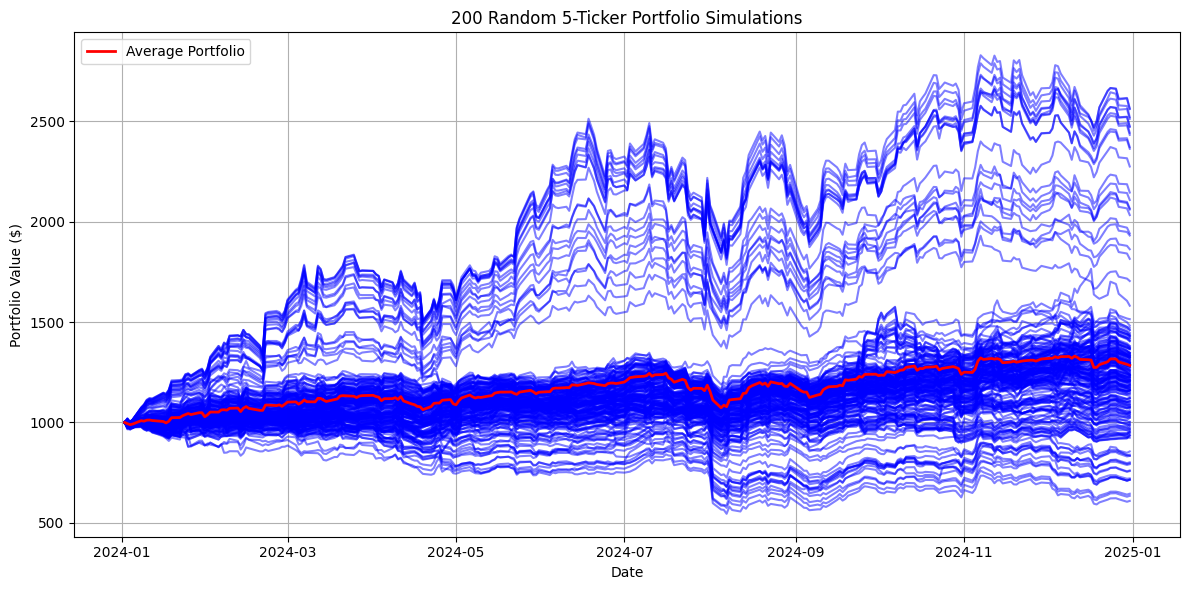

In [8]:
import yfinance as yf
import pandas as pd
import random
import matplotlib.pyplot as plt
import os

# --- Parameters ---
universe = [
    "AAPL","MSFT","GOOG","AMZN","META","NFLX","TSLA","NVDA","BABA","INTC",
    "ADBE","PYPL","CSCO","ORCL","CRM","IBM","QCOM","AMD","TXN","SAP",
    "SHOP","UBER","LYFT","SQ","TWTR","SNAP","PINS","DIS","V","MA",
    "JPM","BAC","WFC","C","GS","MS","AXP","HD","LOW","CVX",
    "XOM","BP","KO","PEP","MCD","SBUX","NKE","LULU","GM","F"
]
start_date = "2024-01-01"
end_date = "2025-01-01"
initial_investment = 1000
n_simulations = 200

# --- Create data folder if not exists ---
os.makedirs("../data", exist_ok=True)

# --- Download historical prices once ---
price_data = {}
valid_tickers = []

print("Downloading historical data for all tickers...")
for ticker in universe:
    try:
        data = yf.download(ticker, start=start_date, end=end_date, auto_adjust=True, progress=False)["Close"]
        if not data.empty:
            price_data[ticker] = data
            valid_tickers.append(ticker)
    except:
        continue

print(f"Successfully downloaded {len(valid_tickers)} tickers out of {len(universe)}")

if len(valid_tickers) < 5:
    raise ValueError("Not enough valid tickers to run simulations.")

# --- Function to get free float weights ---
def get_free_float_weights(tickers):
    results = []
    for symbol in tickers:
        try:
            info = yf.Ticker(symbol).info
            free_float = info.get("floatShares", None)
            if free_float is not None:
                free_float_b = round(free_float / 1e9, 3)
                results.append({"Ticker": symbol, "Free Float (B)": free_float_b})
        except:
            continue
    df = pd.DataFrame(results)
    if df.empty:
        return df
    total_free_float = df["Free Float (B)"].sum()
    df["Free Float Weight"] = df["Free Float (B)"].apply(lambda x: round(x / total_free_float, 4) if x else 0)
    return df

# --- Run simulations ---
all_portfolios = []

for sim in range(n_simulations):
    tickers = random.sample(valid_tickers, 5)
    
    # Get free float weights
    df_weights = get_free_float_weights(tickers)
    tickers_with_data = [t for t in tickers if t in df_weights["Ticker"].values and t in price_data]
    
    if len(tickers_with_data) < 1:
        continue  # Skip this simulation
    
    # Align price data
    df_prices = pd.concat([price_data[t][t].rename(t) for t in tickers_with_data], axis=1)
    df_prices = df_prices.dropna(axis=1, how='any')
    tickers_with_data = df_prices.columns.tolist()
    
    if len(tickers_with_data) < 1:
        continue
    
    # Update weights for tickers with data
    weights_series = pd.Series(df_weights.set_index("Ticker").loc[tickers_with_data]["Free Float Weight"])
    
    # Daily percentage change
    pct_change = df_prices.pct_change().fillna(0)
    
    # Portfolio value
    portfolio_value = [initial_investment]
    for i in range(1, len(pct_change)):
        prev_value = portfolio_value[-1]
        daily_return = (weights_series * pct_change.iloc[i]).sum()
        new_value = prev_value * (1 + daily_return)
        portfolio_value.append(new_value)
    
    all_portfolios.append(pd.Series(portfolio_value, index=pct_change.index))

# --- Combine simulations ---
if len(all_portfolios) == 0:
    raise ValueError("No portfolios were successfully simulated.")
df_all = pd.concat(all_portfolios, axis=1)



# --- Plot ---
plt.figure(figsize=(12,6))
plt.plot(df_all, color='blue', alpha=0.5)
plt.plot(df_all.mean(axis=1), color='red', label='Average Portfolio', linewidth=2)
plt.title(f"{n_simulations} Random 5-Ticker Portfolio Simulations")
plt.xlabel("Date")
plt.ylabel("Portfolio Value ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [4]:
df_list = []
for t in tickers_with_data:
    df = price_data[t]

    # Try to pick "Close" if available, otherwise "Adj Close"
    if "Close" in df.columns:
        series = df["Close"]
    elif "Adj Close" in df.columns:
        series = df["Adj Close"]
    else:
        print(f"⚠️ Skipping {t}: no 'Close' or 'Adj Close' column")
        continue

    df_list.append(series.rename(t))

# Only concat if we got valid data
if df_list:
    df_prices = pd.concat(df_list, axis=1)
else:
    raise ValueError("No valid price data found for any ticker")


⚠️ Skipping XOM: no 'Close' or 'Adj Close' column
⚠️ Skipping AXP: no 'Close' or 'Adj Close' column
⚠️ Skipping TXN: no 'Close' or 'Adj Close' column
⚠️ Skipping MS: no 'Close' or 'Adj Close' column
⚠️ Skipping JPM: no 'Close' or 'Adj Close' column


ValueError: No valid price data found for any ticker

In [5]:
# Inspect first few tickers to see column names
for i, t in enumerate(tickers_with_data[:5]):  # just check first 5
    print(f"{t}: {price_data[t].columns.tolist()}")


XOM: ['XOM']
AXP: ['AXP']
TXN: ['TXN']
MS: ['MS']
JPM: ['JPM']
